# Rule Based Classifier
The rule-based can be described directly by the morphological differences between benign and
malignant cells. There is not available information about color of cell nucleus in the dataset, therefore,
the classifier has the following structure:

`If [cell size is abnormal]
or [cell shape is abnormal]
or [cell texture is abnormal]
or [cell homogeneity is abnormal],
then: diagnosis is malignant,
otherwise: diagnosis is benign.`

These qualitative conditions can be described into quantitative conditions by selecting features from
the dataset. The relation between these conditions is described in the following table:

| Indicator | Feature |
| :--- | :--- |
| Cell size | area_0 |
| Cell shape | concave_points_2 |
| Cell texture | texture_1 |
| Cell homogeneity | symmetry_1 |

We can define abnormality as a high deviation from typical benign morphology. We must assume that
benign tissue has stable features and extreme deviations mean malignant cells. For the feature $i$, let
${x_i}$ denote its value and the following condition:

$$
x_i = \begin{cases} 
\text{malignant}, & x_i > \mu_i + k\sigma_i \\ 
\text{benign}, & \text{otherwise} 
\end{cases}
$$

**Where:**
*   $\mu_i$: is the mean for feature $i$ among benign cases.
*   $\sigma_i$: is the standard deviation for feature $i$ among benign cases.
*   $k$: is a sensitivity parameter.

### Rule-Based Classifier class
Initializes with the means and standard deviations for each feature, and the parameter $k$. The `predict()` function receives a numpy array refering to df.values of a dataframe. It returns a numpy array with the binary classification values.

In [ ]:
import numpy as np

class RuleBasedClassifier:
    def __init__(self, means, stds, k=2):
        self.means = means
        self.stds = stds
        self.k = k
        
    def predict(self, X):
        thresholds = self.means + self.k * self.stds
        abnormal = X > thresholds
        pred = np.any(abnormal, axis=1)
        return pred.astype(int)

We read the dataset from file `wdbc.pkl` and select the quantitative features. We divide the dataset in a distribution of 60% training, 20% validation and 20% testing with stratification to maintain class distribution.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_pickle("wdbc.pkl")

features = ['area_0', 'concave points_2', 'texture_1', 'symmetry_1']

X = df[features].values
y = df['malignant'].values

X_full, X_test, y_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.25, random_state=42, stratify=y_full
)

We get the means and standard deviations vector only from benign entries.

In [ ]:
X_train_benign = X_train[y_train == 0]

means = X_train_benign.mean(axis=0)
stds = X_train_benign.std(axis=0)

A search through the range [1,5] with a step of 0.2. The best $k$ value, maximizing malignant class, but maintaining a considerable recall for bening class, is $k=1.6$. Since it is a medical application, it is better to have an agressive model, with the cost of false positives.

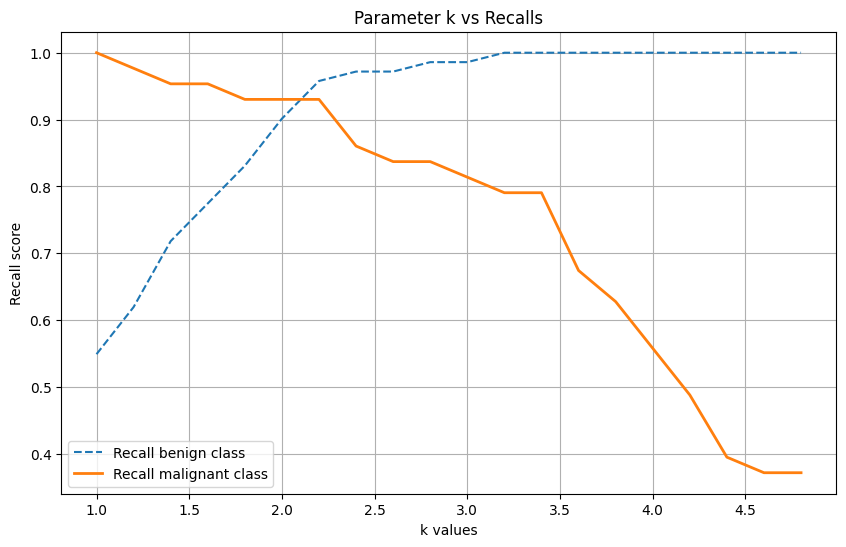

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, classification_report

k_vals = []
recalls0 = []
recalls1 = []

for k in np.arange(1, 5, 0.2):
    model = RuleBasedClassifier(means, stds, k=k)
    pred_val = model.predict(X_val)
    k_vals.append(k)
    recalls0.append(recall_score(y_val, pred_val, pos_label=0))
    recalls1.append(recall_score(y_val, pred_val, pos_label=1))
    #     print(f"\n=== k = {k} ===")
    #     print(classification_report(y_val, pred_val))

plt.figure(figsize=(10, 6))
plt.plot(k_vals, recalls0, label='Recall benign class', linestyle='--')
plt.plot(k_vals, recalls1, label='Recall malignant class', linewidth=2)
plt.legend()
plt.title('Parameter k vs Recalls')
plt.xlabel('k values')
plt.ylabel('Recall score')
plt.grid(True)
plt.show()

The classification report for $k=1.6$ is the following:

In [13]:
k = 1.6
model = RuleBasedClassifier(means, stds, k=k)
pred_val = model.predict(X_val)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86        71
           1       0.72      0.95      0.82        43

    accuracy                           0.84       114
   macro avg       0.84      0.86      0.84       114
weighted avg       0.87      0.84      0.84       114



Once $k$ is calculated, it is possible to visualize where the decision frontier is in the training data. For example, for `area_0`:

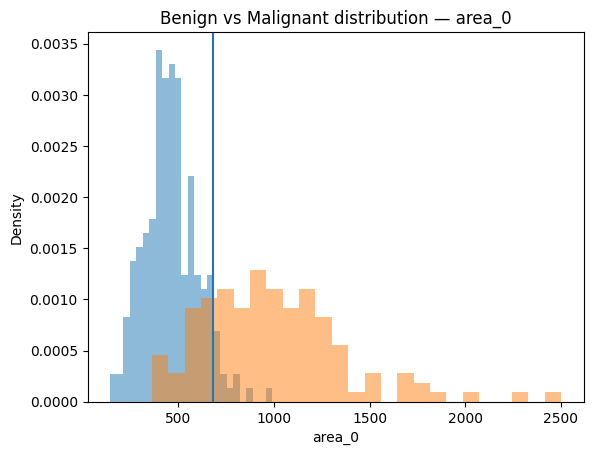

In [14]:
feature_name = 'area_0'
feature_index = features.index(feature_name)

benign = X_train[y_train == 0][:, feature_index]
malignant = X_train[y_train == 1][:, feature_index]

mu = benign.mean()
sigma = benign.std()

x = np.linspace(min(X_train[:, feature_index]), max(X_train[:, feature_index]), 300)

plt.hist(benign, bins=25, density=True, alpha=0.5)
plt.hist(malignant, bins=25, density=True, alpha=0.5)

plt.axvline(mu + k * sigma)

plt.title(f"Benign vs Malignant distribution — {feature_name}")
plt.xlabel(feature_name)
plt.ylabel("Density")
plt.show()

In the validation data, we can count how many times a feature triggers the classifier, to visualize which variables are more relevant for the classifier.

In [15]:
feature_counts = {}
thresholds = means + k * stds

for i, f in enumerate(features):
    abnormal = X_val[:, i] > thresholds[i]
    feature_counts[f] = abnormal.sum()

print(feature_counts)

{'area_0': np.int64(37), 'concave points_2': np.int64(49), 'texture_1': np.int64(4), 'symmetry_1': np.int64(9)}


Finally, we compute `means` and `stds` with both training and validation sets (with only benign class again), then we can predict for testing set.

In [16]:
X_full_benign = X_full[y_full == 0]

means = X_full_benign.mean(axis=0)
stds = X_full_benign.std(axis=0)

model = RuleBasedClassifier(means, stds, k)
pred_test = model.predict(X_test)

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87        72
           1       0.72      0.98      0.83        42

    accuracy                           0.85       114
   macro avg       0.85      0.88      0.85       114
weighted avg       0.89      0.85      0.85       114



The confusion matrix is the following:

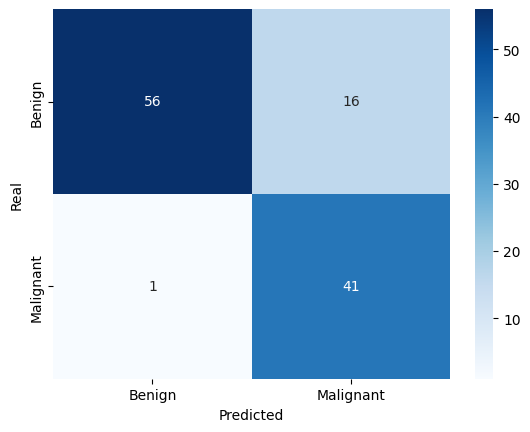

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, pred_test)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()